# Predicting IBM 1-min-time series
* It is possible to get (ocationally) a signal with around 1% recall and around 80% precision using a regularized logistic regression
* If we managed to do this on many stocks we would be able to build a reasonable strategy from there.
* What if we negate the target and study NPV instead: recall improves ! (this idea might work !!!)
* Use naive Bayes: BernoulliNB out of the box is producing nice precision-recall curves
* What if we deal with class weights in the logistic regressions? class_weight
* Models are finding things, the behaviour is really not random. The fact that the thresholds in testing vs training are expected to be so different, maybe have to do with the way in which we are scaling things in our pipeline, also, PCA does seam to be helping a lot !!!!!!!!!!!!
* Again: can class weights help?

In [1]:
import sys
sys.path.append("/Users/lduque/Desktop/myProjects/moneyManager/marketUtilities")

In [2]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [3]:
#class_weight={True:1, False:1}

In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from modeling.createTrainingDataSet import createTrainingDataSet
from modeling.StockModel import generatePipeline
from modeling.plotPrecisionRecallThresholds import plotPrecisionRecallThresholds # soon to deprecate
from modeling.precisionRecallUtilities import plotTrainTestPrecisionRecallUsingModel
pd.set_option('display.max_columns', None)

In [5]:
startDay=datetime(2019,1,1)
endDay= datetime(2019,1,22)
df = createTrainingDataSet('IBM',  startDay=startDay, endDay=endDay, pastStart=40)
df = df[['consolidated', 'volume', 'target']]

In [6]:
df.target.value_counts()

True     2726
False    2344
Name: target, dtype: int64

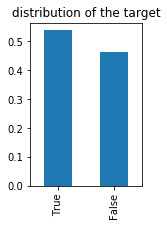

In [7]:
(df.target.value_counts()/len(df)).plot.bar(figsize=(2,3), title='distribution of the target');

In [8]:
df.volume.apply(lambda x: np.mean(x)).value_counts().sort_index()

2681.414634     1
2689.365854     1
2701.634146     1
2711.219512     1
2715.780488     1
               ..
27375.878049    1
27409.097561    1
27409.926829    1
27445.512195    1
27451.512195    1
Name: volume, Length: 4999, dtype: int64

In [9]:
X = df.copy()
y = X.pop('target')

In [10]:
trainEnds = 2*len(X)//3
Xtrain, ytrain = X[:trainEnds], y[:trainEnds] 
Xtest, ytest = X[trainEnds:], y[trainEnds:]

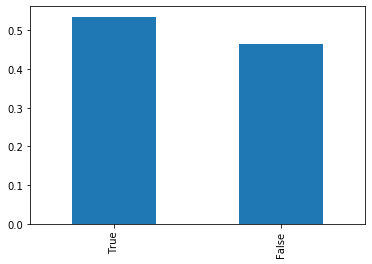

In [11]:
(ytest.value_counts()/len(ytest)).plot.bar()

In [12]:
(ytest.value_counts()/len(ytest))

True     0.535503
False    0.464497
Name: target, dtype: float64

In [13]:
(ytrain.value_counts()/len(ytrain))

True     0.538757
False    0.461243
Name: target, dtype: float64

# Debugging the pipeline
* So far we have 83 features

In [14]:
pipeline = generatePipeline()
pipeline.fit(Xtrain)
XtrainTrf = pipeline.transform(Xtrain)
XtestTrf = pipeline.transform(Xtest)
XtrainTrf.shape

/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


(3380, 63)

In [15]:
XtestTrf.describe()

,consolidated_max,consolidated_argmax,consolidated_min,consolidated_argmin,consolidated_mean,consolidated_std,consolidated_var,consolidated_median,consolidated_kurtosis,consolidated_skew,consolidated_numpos,consolidated_posvar,consolidated_numnan,consolidated_last,consolidated_first,volume_max,volume_argmax,volume_min,volume_argmin,volume_mean,volume_std,volume_var,volume_median,volume_kurtosis,volume_skew,volume_numpos,volume_posvar,volume_numnan,volume_last,volume_first,consolidatedDifference_max,consolidatedDifference_argmax,consolidatedDifference_min,consolidatedDifference_argmin,consolidatedDifference_mean,consolidatedDifference_std,consolidatedDifference_var,consolidatedDifference_median,consolidatedDifference_kurtosis,consolidatedDifference_skew,consolidatedDifference_numpos,consolidatedDifference_posvar,consolidatedDifference_numnan,consolidatedDifference_last,consolidatedDifference_first,volumeDifference_max,volumeDifference_argmax,volumeDifference_min,volumeDifference_argmin,volumeDifference_mean,volumeDifference_std,volumeDifference_var,volumeDifference_median,volumeDifference_kurtosis,volumeDifference_skew,volumeDifference_numpos,volumeDifference_posvar,volumeDifference_numnan,volumeDifference_last,volumeDifference_first,hour,minute,hourminute
count,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000
mean,0.078131,0.541731,0.924656,0.454808,0.428465,0.095387,0.022785,0.0,0.046324,0.428738,0.998757,0.011545,0.0,0.383058,0.672943,0.193816,0.527278,0.534643,0.485488,0.262903,0.218831,0.182314,0.0,0.204467,0.349552,0.999911,0.175141,0.0,0.058666,0.056925,0.047306,0.479669,0.886376,0.508739,0.348944,0.088097,0.029560,0.461231,0.083902,0.395577,0.603676,0.012175,0.0,0.263954,0.268623,0.159238,0.518677,0.817984,0.508952,0.506346,0.197317,0.168503,0.574428,0.145310,0.501233,0.776604,0.174573,0.0,0.485969,0.470095,0.487828,0.518855,0.509853
std,0.086929,0.336825,0.076842,0.339199,0.040900,0.093382,0.039849,0.0,0.041673,0.066547,0.007974,0.032004,0.0,0.065232,0.059157,0.360744,0.304595,0.150471,0.305348,0.223784,0.357004,0.749103,0.0,0.192493,0.185733,0.002105,0.805912,0.0,0.071397,0.080207,0.087927,0.298066,0.211606,0.297827,0.077646,0.114033,0.064785,0.084000,0.156243,0.123966,0.103203,0.040207,0.0,0.022509,0.022811,0.354565,0.298843,0.358988,0.300980,0.055715,0.354041,0.803827,0.128769,0.124526,0.077806,0.064580,0.967448,0.0,0.048807,0.067686,0.273313,0.295108,0.284133
min,-0.010819,0.000000,0.557691,0.000000,0.219363,-0.003092,-0.000189,0.0,0.001439,0.100038,0.900000,-0.000221,0.0,0.087936,0.373663,0.002442,0.000000,0.013434,0.000000,-0.012887,0.003892,0.000643,0.0,0.001373,0.007446,0.950000,0.000375,0.0,0.000401,0.000484,-0.001217,0.000000,-0.415528,0.000000,0.074287,-0.014965,-0.001762,0.194041,0.003951,-0.197063,0.212121,-0.000050,0.0,-0.103433,-0.104803,0.005693,0.000000,-1.774901,0.000000,-0.837902,0.010538,0.001465,0.055815,0.003416,-0.037847,0.538462,0.001187,0.0,-0.667948,-1.203929,0.000000,0.000000,0.000000
25%,0.025994,0.250000,0.906095,0.125000,0.417798,0.028417,0.002577,0.0,0.028265,0.388301,1.000000,0.001146,0.0,0.353557,0.651894,0.062909,0.250000,0.438667,0.225000,0.134737,0.076620,0.017320,0.0,0.074755,0.210482,1.000000,0.010454,0.0,0.031587,0.029168,0.009552,0.230769,0.885633,0.256410,0.304531,0.025439,0.003888,0.412418,0.026264,0.354723,0.5454

In [16]:
XtestTrf.isna().sum()

consolidated_max          0
consolidated_argmax       0
consolidated_min          0
consolidated_argmin       0
consolidated_mean         0
                         ..
volumeDifference_last     0
volumeDifference_first    0
hour                      0
minute                    0
hourminute                0
Length: 63, dtype: int64

In [17]:
XtestTrf.describe()

,consolidated_max,consolidated_argmax,consolidated_min,consolidated_argmin,consolidated_mean,consolidated_std,consolidated_var,consolidated_median,consolidated_kurtosis,consolidated_skew,consolidated_numpos,consolidated_posvar,consolidated_numnan,consolidated_last,consolidated_first,volume_max,volume_argmax,volume_min,volume_argmin,volume_mean,volume_std,volume_var,volume_median,volume_kurtosis,volume_skew,volume_numpos,volume_posvar,volume_numnan,volume_last,volume_first,consolidatedDifference_max,consolidatedDifference_argmax,consolidatedDifference_min,consolidatedDifference_argmin,consolidatedDifference_mean,consolidatedDifference_std,consolidatedDifference_var,consolidatedDifference_median,consolidatedDifference_kurtosis,consolidatedDifference_skew,consolidatedDifference_numpos,consolidatedDifference_posvar,consolidatedDifference_numnan,consolidatedDifference_last,consolidatedDifference_first,volumeDifference_max,volumeDifference_argmax,volumeDifference_min,volumeDifference_argmin,volumeDifference_mean,volumeDifference_std,volumeDifference_var,volumeDifference_median,volumeDifference_kurtosis,volumeDifference_skew,volumeDifference_numpos,volumeDifference_posvar,volumeDifference_numnan,volumeDifference_last,volumeDifference_first,hour,minute,hourminute
count,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.0,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000
mean,0.078131,0.541731,0.924656,0.454808,0.428465,0.095387,0.022785,0.0,0.046324,0.428738,0.998757,0.011545,0.0,0.383058,0.672943,0.193816,0.527278,0.534643,0.485488,0.262903,0.218831,0.182314,0.0,0.204467,0.349552,0.999911,0.175141,0.0,0.058666,0.056925,0.047306,0.479669,0.886376,0.508739,0.348944,0.088097,0.029560,0.461231,0.083902,0.395577,0.603676,0.012175,0.0,0.263954,0.268623,0.159238,0.518677,0.817984,0.508952,0.506346,0.197317,0.168503,0.574428,0.145310,0.501233,0.776604,0.174573,0.0,0.485969,0.470095,0.487828,0.518855,0.509853
std,0.086929,0.336825,0.076842,0.339199,0.040900,0.093382,0.039849,0.0,0.041673,0.066547,0.007974,0.032004,0.0,0.065232,0.059157,0.360744,0.304595,0.150471,0.305348,0.223784,0.357004,0.749103,0.0,0.192493,0.185733,0.002105,0.805912,0.0,0.071397,0.080207,0.087927,0.298066,0.211606,0.297827,0.077646,0.114033,0.064785,0.084000,0.156243,0.123966,0.103203,0.040207,0.0,0.022509,0.022811,0.354565,0.298843,0.358988,0.300980,0.055715,0.354041,0.803827,0.128769,0.124526,0.077806,0.064580,0.967448,0.0,0.048807,0.067686,0.273313,0.295108,0.284133
min,-0.010819,0.000000,0.557691,0.000000,0.219363,-0.003092,-0.000189,0.0,0.001439,0.100038,0.900000,-0.000221,0.0,0.087936,0.373663,0.002442,0.000000,0.013434,0.000000,-0.012887,0.003892,0.000643,0.0,0.001373,0.007446,0.950000,0.000375,0.0,0.000401,0.000484,-0.001217,0.000000,-0.415528,0.000000,0.074287,-0.014965,-0.001762,0.194041,0.003951,-0.197063,0.212121,-0.000050,0.0,-0.103433,-0.104803,0.005693,0.000000,-1.774901,0.000000,-0.837902,0.010538,0.001465,0.055815,0.003416,-0.037847,0.538462,0.001187,0.0,-0.667948,-1.203929,0.000000,0.000000,0.000000
25%,0.025994,0.250000,0.906095,0.125000,0.417798,0.028417,0.002577,0.0,0.028265,0.388301,1.000000,0.001146,0.0,0.353557,0.651894,0.062909,0.250000,0.438667,0.225000,0.134737,0.076620,0.017320,0.0,0.074755,0.210482,1.000000,0.010454,0.0,0.031587,0.029168,0.009552,0.230769,0.885633,0.256410,0.304531,0.025439,0.003888,0.412418,0.026264,0.354723,0.5454

# Naive Bayes

In [18]:
clf = BernoulliNB()
clf.fit(XtrainTrf, ytrain); 

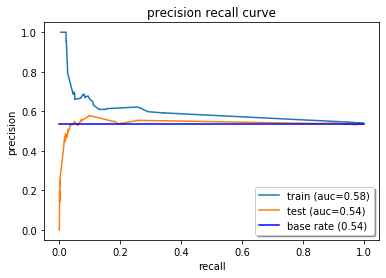

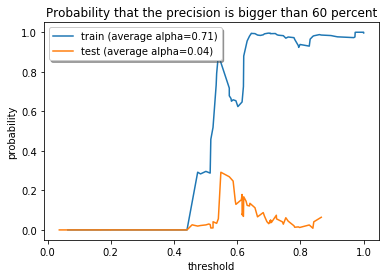

In [19]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

# No regularization
* Performance is not awesome
* Huge overfit: notice how different precision and recall curves are.

In [20]:
clf =LogisticRegression(penalty='none', max_iter=10000)
clf.fit(XtrainTrf, ytrain);  

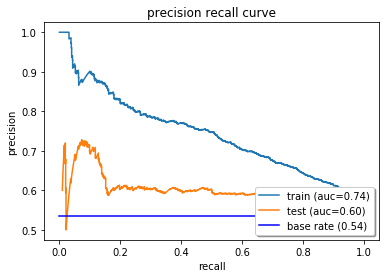

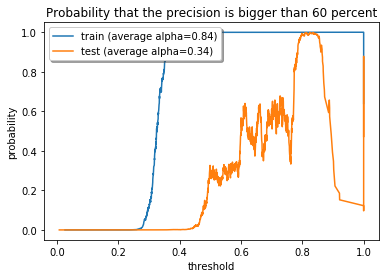

In [21]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

# L1 regularization

In [22]:
C = 10**np.linspace(-4,1,50) 
grid_parameters = {
    'C': C,
    'penalty':['l1']
}

clf = GridSearchCV(LogisticRegression(solver='saga',max_iter=10000, multi_class='ovr', C=C), grid_parameters, scoring='average_precision', cv=2, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

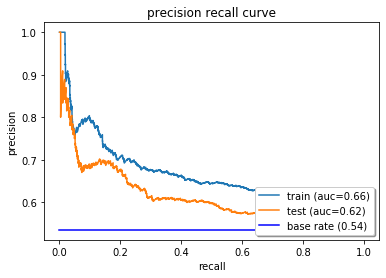

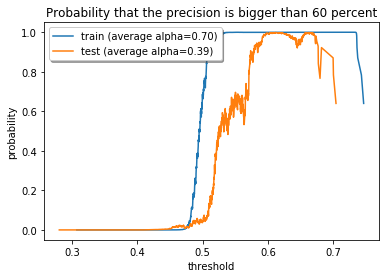

In [23]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.6292916174312034
---
hour                             0.726557
consolidatedDifference_argmax    0.582401
volume_min                       0.454927
consolidatedDifference_argmin    0.268818
volume_std                       0.229205
                                   ...   
consolidatedDifference_var       0.000000
consolidatedDifference_std       0.000000
consolidatedDifference_mean      0.000000
consolidatedDifference_max       0.000000
consolidated_max                 0.000000
Length: 63, dtype: float64
---
LogisticRegression(C=0.09102981779915217, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


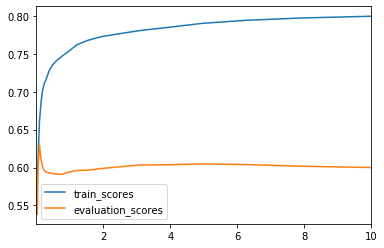

In [24]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

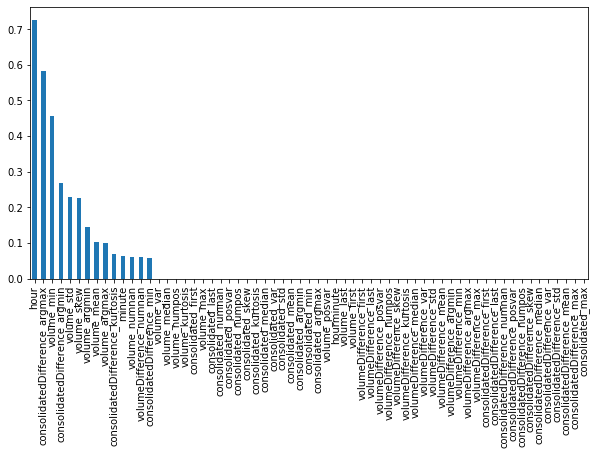

In [25]:
pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False).plot.bar(figsize=(10,5));

# L2 regularization

In [26]:
C = 10**np.linspace(-5,0,100) 
grid_parameters = {
    'C': C,
    'penalty':['l2']
}

clf = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=10000, C=C), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

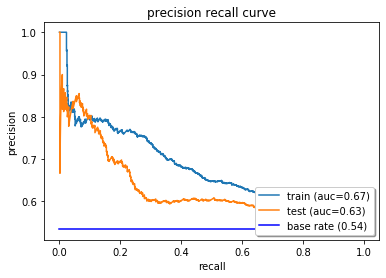

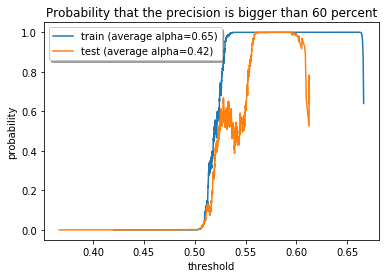

In [27]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.5643996117941085
---
consolidatedDifference_argmax    0.174572
hourminute                       0.156375
hour                             0.154226
volume_argmin                    0.124485
volume_min                       0.099351
                                   ...   
consolidatedDifference_skew      0.001449
consolidated_kurtosis            0.000025
consolidatedDifference_var       0.000016
volume_median                    0.000000
consolidated_median              0.000000
Length: 63, dtype: float64
---
LogisticRegression(C=0.0047508101621027985, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


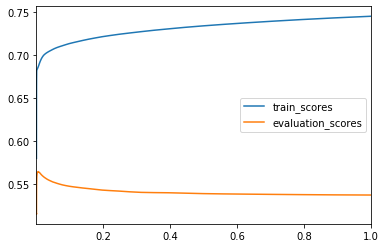

In [28]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

# Random Forest
* Horrible overift ... for now! ... unexpectedly hard to control !!

In [29]:
grid_parameters = {
    #'min_samples_leaf' : [100, 1000, 2000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8,9, 10],
    'n_estimators': [5, 10, 100],   
    'max_features': ['sqrt', 0.1, 0.2, 0.5, 0.8]
}

clf = GridSearchCV(RandomForestClassifier(), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores})

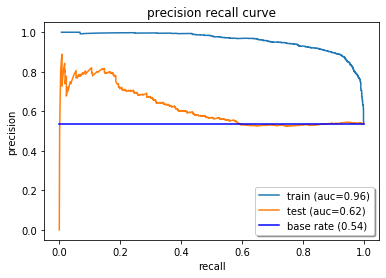

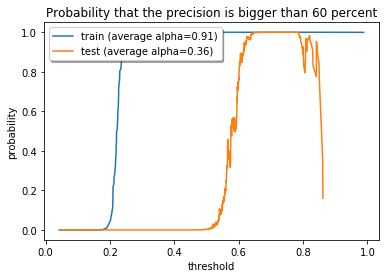

In [30]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

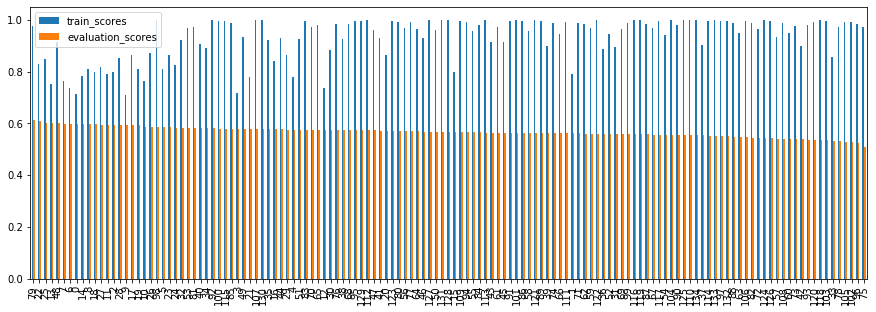

In [31]:
ds.sort_values(by='evaluation_scores', ascending=False).plot.bar(figsize=(15,5))

In [32]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=0.1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

feature importance


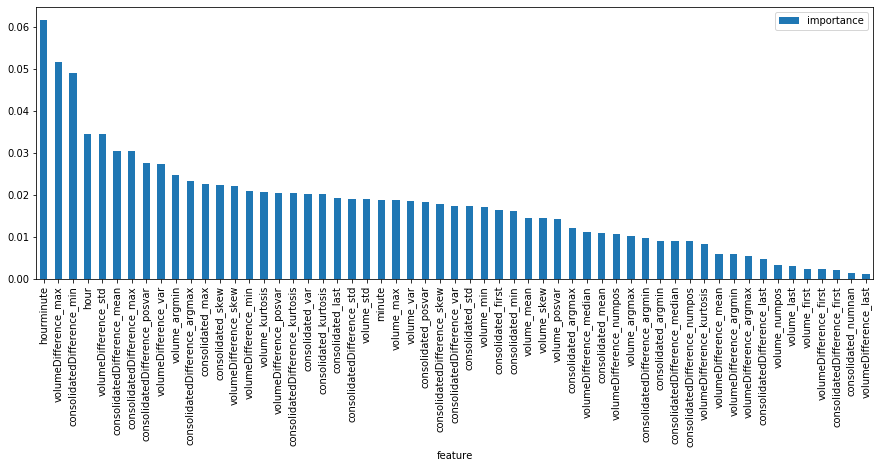

In [33]:
print("feature importance")
feature_importance = pd.DataFrame({'feature': XtrainTrf.columns, 'importance':clf.best_estimator_.feature_importances_}).set_index('feature').sort_values(by=['importance'], ascending=False)
feature_importance[feature_importance.importance>0].plot.bar(figsize=(15,5))